In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
universe = {
    'Utilities': {
        'Large Cap': ['NEE', 'DUK'],
        'Mid Cap': ['ATO', 'CMS'],
        'Small Cap': ['CNP', 'LNT'],
        'Equity ETFs': ['XLU'],
    },
    'Healthcare': {
        'Large Cap': ['JNJ', 'PFE'],
        'Mid Cap': ['HCA', 'HOLX'],
        'Small Cap': ['CRL', 'ISRG'],
        'Equity ETFs': ['XLV'],
    },
    'Technology': {
        'Large Cap': ['AAPL', 'MSFT'],
        'Mid Cap': ['AKAM', 'FFIV'],
        'Small Cap': ['ANSS', 'CDNS'],
        'Equity ETFs': ['QQQ', 'XLK'],
    },
    'Financials': {
        'Large Cap': ['JPM', 'BAC'],
        'Mid Cap': ['MTB', 'RF'],
        'Small Cap': ['FHN', 'PB'],
        'Equity ETFs': ['XLF'],
    }
}

# Flatten the 'universe' dictionary to create a single list of all ticker symbols.
# This list will be used to download historical data from Yahoo Finance.
all_tickers = []
for sector in universe:
    for cap_group in universe[sector]:
        all_tickers.extend(universe[sector][cap_group])

# Define the date range for data download.
# Using a broad range to ensure sufficient historical data for analysis.
start_date = '2014-01-01'
end_date = '2025-12-31' # Set to a future date to ensure current data is fetched up to today

print("[*********************100%***********************]  Downloading data...")
# Download adjusted close prices for all tickers using yfinance.
# 'auto_adjust=False' ensures raw prices are downloaded, and then we select 'Adj Close'.
# '.dropna()' is crucial to remove any rows with missing data, ensuring clean data for calculations.
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close'].dropna()

# Display the first few rows of the downloaded data to verify successful retrieval and structure.
print("\n--- Raw Price Data (First 5 Rows) ---")
print(data.head())

[*********************100%***********************]  Downloading data...


[*********************100%***********************]  29 of 29 completed


--- Raw Price Data (First 5 Rows) ---
Ticker           AAPL       AKAM       ANSS        ATO        BAC   CDNS  \
Date                                                                       
2014-01-02  17.192822  46.529999  86.010002  33.599113  12.820024  14.01   
2014-01-03  16.815168  46.450001  85.599998  33.651764  13.066871  14.17   
2014-01-06  16.906858  46.110001  85.019997  33.238079  13.265938  14.27   
2014-01-07  16.785957  47.009998  85.580002  33.982727  13.138538  14.34   
2014-01-08  16.892254  46.680000  85.279999  34.163239  13.202238  14.42   

Ticker            CMS        CNP        CRL        DUK  ...        MTB  \
Date                                                    ...              
2014-01-02  18.511246  15.150216  52.880001  42.170620  ...  84.022713   
2014-01-03  18.504211  15.143586  53.459999  42.034451  ...  84.132248   
2014-01-06  18.384556  15.163506  52.980000  42.059223  ...  83.869347   
2014-01-07  18.511246  15.322839  56.299999  42.387222  ..


--- Daily Log Returns (First 5 Rows) ---
Ticker          AAPL      AKAM      ANSS       ATO       BAC      CDNS  \
Date                                                                     
2014-01-03 -0.022211 -0.001721 -0.004778  0.001566  0.019072  0.011356   
2014-01-06  0.005438 -0.007347 -0.006799 -0.012369  0.015120  0.007032   
2014-01-07 -0.007177  0.019330  0.006565  0.022156 -0.009650  0.004893   
2014-01-08  0.006313 -0.007044 -0.003512  0.005298  0.004837  0.005563   
2014-01-09 -0.012852  0.019937 -0.009070  0.005051  0.014966 -0.006959   

Ticker           CMS       CNP       CRL       DUK  ...       MTB       NEE  \
Date                                                ...                       
2014-01-03 -0.000380 -0.000438  0.010908 -0.003234  ...  0.001303  0.001305   
2014-01-06 -0.006487  0.001315 -0.009019  0.000589  ... -0.003130  0.000474   
2014-01-07  0.006867  0.010453  0.060780  0.007768  ...  0.005471  0.007319   
2014-01-08 -0.002284 -0.010453 -0.004986 -0.

<Figure size 1200x600 with 0 Axes>

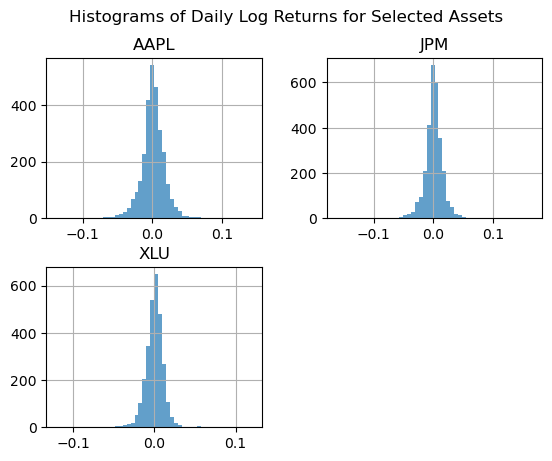

In [10]:
# Calculate daily log returns from the adjusted close prices.
# Log returns are preferred in financial analysis for their additive properties
# and better approximation of continuously compounded returns.
returns = np.log(data / data.shift(1)).dropna()

# Display the first few rows of the calculated returns.
print("\n--- Daily Log Returns (First 5 Rows) ---")
print(returns.head())

# Calculate and display descriptive statistics for the returns.
# This provides insights into the mean, standard deviation, min/max, etc., of each asset's returns.
print("\n--- Returns Descriptive Statistics ---")
print(returns.describe())

# Plot histograms of returns for a few selected assets to visualize their distribution.
# This helps in understanding the skewness and kurtosis of returns.
plt.figure(figsize=(12, 6))
returns[['AAPL', 'JPM', 'XLU']].hist(bins=50, alpha=0.7)
plt.suptitle('Histograms of Daily Log Returns for Selected Assets')
plt.xlabel('Daily Log Return')
plt.ylabel('Frequency')
plt.show()

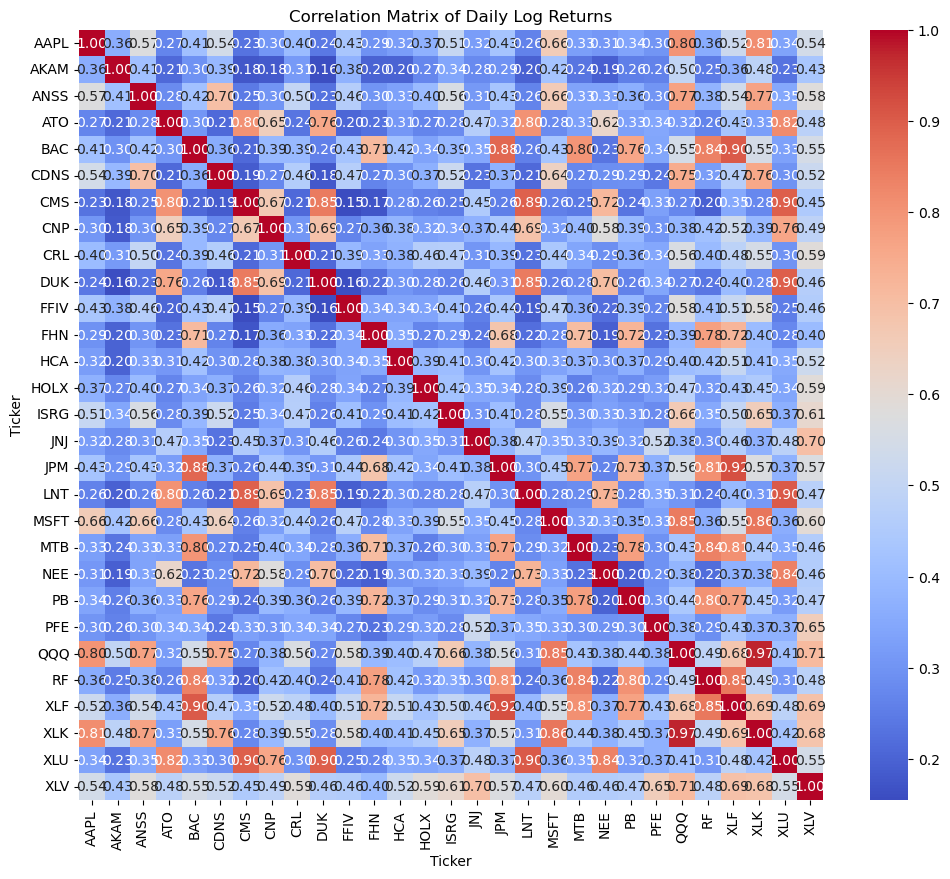

In [8]:
# Plot a heatmap of the correlation matrix of returns.
# This visualizes the relationships between asset returns, crucial for diversification.
plt.figure(figsize=(12, 10))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Daily Log Returns')
plt.show()


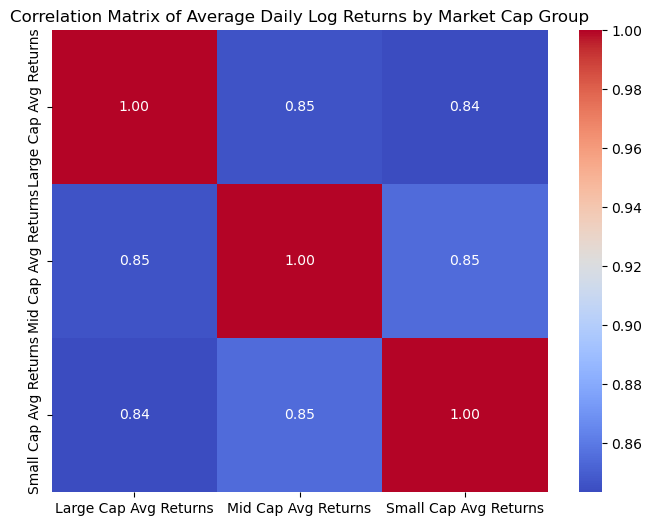

In [30]:
large_cap_tickers = []
mid_cap_tickers = []
small_cap_tickers = []

for sector_data in universe.values():
    if 'Large Cap' in sector_data:
        large_cap_tickers.extend(sector_data['Large Cap'])
    if 'Mid Cap' in sector_data:
        mid_cap_tickers.extend(sector_data['Mid Cap'])
    if 'Small Cap' in sector_data:
        small_cap_tickers.extend(sector_data['Small Cap'])

# Filter returns for each cap group and calculate their average daily returns.
# We ensure that only tickers present in the 'returns' DataFrame columns are considered.
large_cap_avg_returns = returns[[t for t in large_cap_tickers if t in returns.columns]].mean(axis=1)
mid_cap_avg_returns = returns[[t for t in mid_cap_tickers if t in returns.columns]].mean(axis=1)
small_cap_avg_returns = returns[[t for t in small_cap_tickers if t in returns.columns]].mean(axis=1)

# Combine these average returns into a new DataFrame for correlation calculation.
cap_group_returns = pd.DataFrame({
    'Large Cap Avg Returns': large_cap_avg_returns,
    'Mid Cap Avg Returns': mid_cap_avg_returns,
    'Small Cap Avg Returns': small_cap_avg_returns
}).dropna() # Drop rows with any NaN values that might result from missing data for a cap group.

# Calculate the correlation matrix for these aggregated cap group returns.
cap_group_corr = cap_group_returns.corr()

# Plot the new heatmap.
plt.figure(figsize=(8, 6)) # Adjusted figure size for fewer categories.
sns.heatmap(cap_group_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Average Daily Log Returns by Market Cap Group')
plt.show()

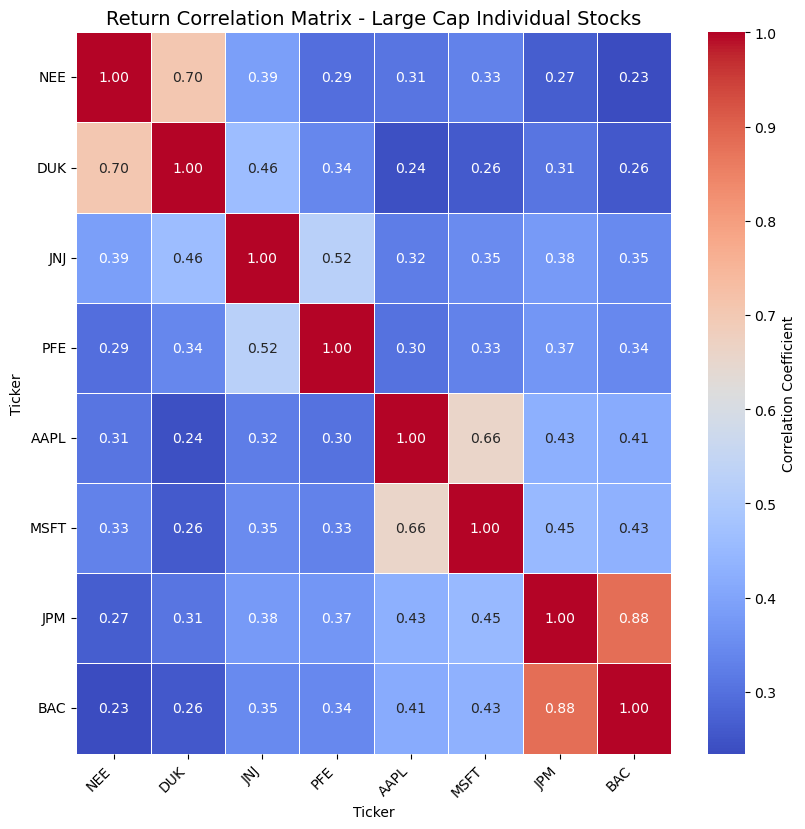

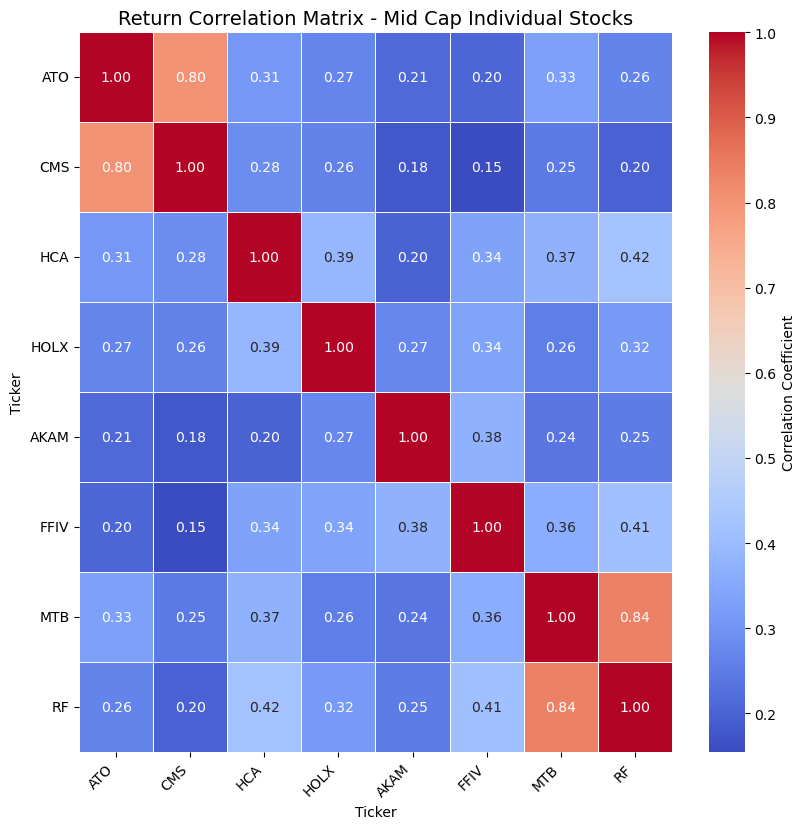

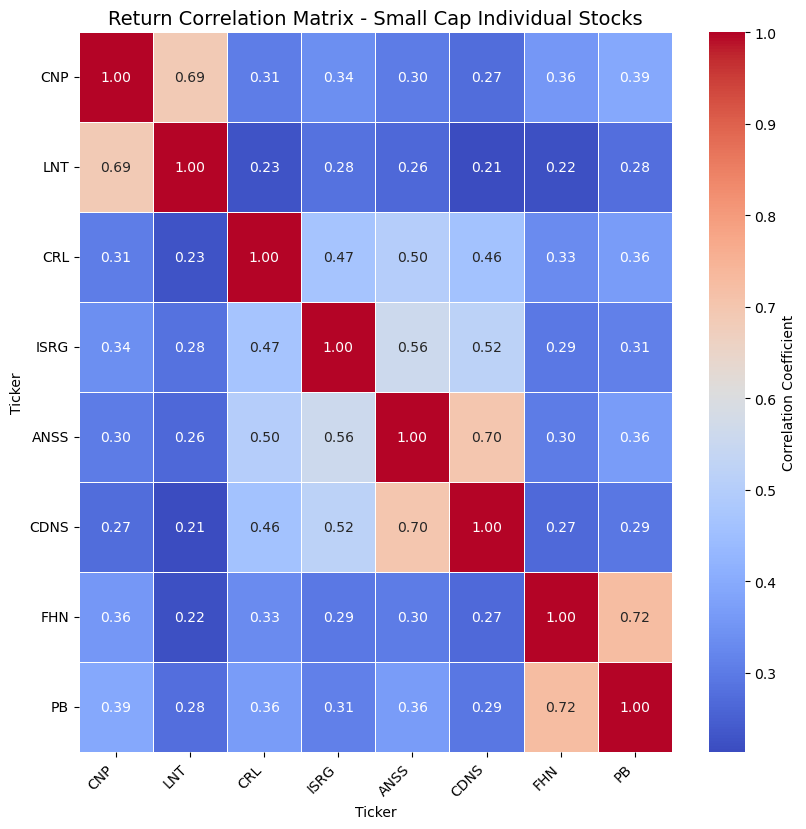

In [36]:
# Dynamically create market_cap_map from the 'universe' dictionary
# This ensures that all tickers fetched are categorized and used for plotting.
market_cap_map = {}
for sector, cap_groups in universe.items():
    for cap_type, tickers_list in cap_groups.items():
        # Exclude 'Equity ETFs' from this specific individual stock analysis if desired,
        # or include them if they are considered individual stocks in this context.
        # For now, we'll include all non-ETF tickers in their respective cap groups.
        if 'ETF' not in cap_type: # Simple check to exclude ETFs from individual stock analysis
            for ticker in tickers_list:
                market_cap_map[ticker] = cap_type

# Group tickers by market cap based on the dynamically created map
groups = {'Large Cap': [], 'Mid Cap': [], 'Small Cap': []}
for ticker, cap in market_cap_map.items():
    if cap in groups and ticker in returns.columns: # Ensure ticker exists in the returns DataFrame
        groups[cap].append(ticker)

# Compute and plot correlation matrix for each market cap group
for cap_group, tickers in groups.items():
    if not tickers: # Skip if no tickers found for the group
        print(f"No tickers found for {cap_group} to plot correlation matrix.")
        continue

    # Subset returns for the current market cap group, dropping columns with all NaN values
    subset_returns = returns[tickers].dropna(axis=1, how='all')

    if subset_returns.empty: # If after dropping NaNs, the DataFrame is empty
        print(f"No valid return data for {cap_group} to plot correlation matrix after dropping NaNs.")
        continue

    # Calculate the correlation matrix for the subset of returns
    corr_matrix = subset_returns.corr()

    # Plot the heatmap
    plt.figure(figsize=(len(tickers) * 0.8 + 2, len(tickers) * 0.8 + 2)) # Dynamic figure size
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title(f'Return Correlation Matrix - {cap_group} Individual Stocks', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


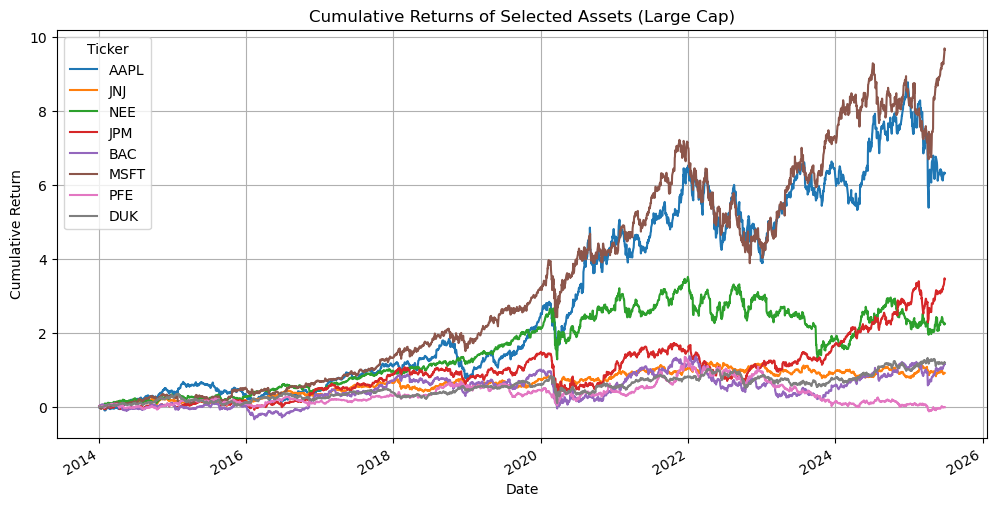

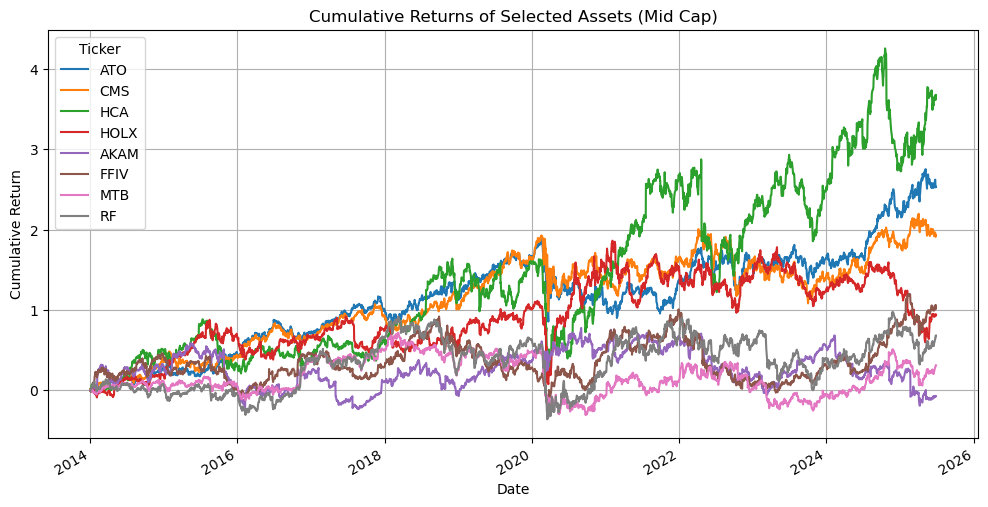

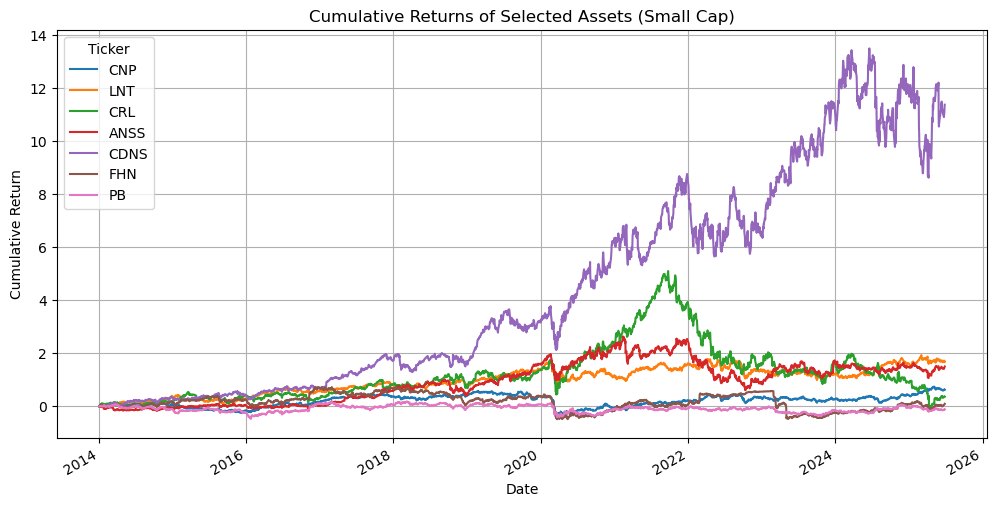

In [32]:
# Visualize time series of cumulative returns for selected tickers (LARGE CAP)
# Select a subset of large-cap tickers for plotting. Ensure they are in the 'returns' DataFrame.
selected_large = [t for t in ['AAPL', 'JNJ', 'NEE', 'JPM', 'BAC','MSFT','PFE','DUK'] if t in returns.columns]
if selected_large: # Check if the list is not empty
    # Calculate cumulative returns: (1 + daily_return).cumprod() - 1
    cum_returns_large = (returns[selected_large] + 1).cumprod() - 1
    plt.figure(figsize=(12,6))
    cum_returns_large.plot(ax=plt.gca()) # Use ax=plt.gca() to plot on the current axes
    plt.title('Cumulative Returns of Selected Assets (Large Cap)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend(title='Ticker')
    plt.show()
else:
    print("No large cap tickers available for cumulative returns plot.")


# Visualize time series of cumulative returns for selected tickers (MID CAP)
# Select a subset of mid-cap tickers for plotting. Ensure they are in the 'returns' DataFrame.
selected_mid = [t for t in ['ATO', 'CMS', 'HCA', 'HOLX','AKAM', 'FFIV', 'MTB', 'RF'] if t in returns.columns]
if selected_mid: # Check if the list is not empty
    cum_returns_mid = (returns[selected_mid] + 1).cumprod() - 1
    plt.figure(figsize=(12,6))
    cum_returns_mid.plot(ax=plt.gca())
    plt.title('Cumulative Returns of Selected Assets (Mid Cap)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend(title='Ticker')
    plt.show()
else:
    print("No mid cap tickers available for cumulative returns plot.")


# Visualize time series of cumulative returns for selected tickers (Small Cap)
# Select a subset of small-cap tickers for plotting. Ensure they are in the 'returns' DataFrame.
selected_small = [t for t in ['CNP', 'LNT', 'CRL', 'ANSS', 'CDNS', 'FHN', 'PB'] if t in returns.columns] # Removed 'HOLX' as it was listed in Mid Cap
if selected_small: # Check if the list is not empty
    cum_returns_small = (returns[selected_small] + 1).cumprod() - 1
    plt.figure(figsize=(12,6))
    cum_returns_small.plot(ax=plt.gca())
    plt.title('Cumulative Returns of Selected Assets (Small Cap)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend(title='Ticker')
    plt.show()
else:
    print("No small cap tickers available for cumulative returns plot.")

In [14]:
market_ticker = 'SPY'
# Download adjusted close prices for the market proxy.
market_data = yf.download(market_ticker, start=start_date, end=end_date, auto_adjust=False)['Adj Close'].dropna()
# Calculate daily log returns for the market proxy.
market_returns = np.log(market_data / market_data.shift(1)).dropna()

# Align the market returns with the asset returns based on common dates.
# This ensures that the regression is performed on synchronized data.
common_dates = returns.index.intersection(market_returns.index)
aligned_returns = returns.loc[common_dates]
aligned_market_returns = market_returns.loc[common_dates]

# Calculate Beta for each asset using linear regression (CAPM).
# Beta measures an asset's sensitivity to market movements.
betas = {}
for ticker in aligned_returns.columns:
    # Reshape data for sklearn's LinearRegression.
    X = aligned_market_returns.values.reshape(-1, 1)
    y = aligned_returns[ticker].values.reshape(-1, 1)

    # Initialize and fit the linear regression model.
    model = LinearRegression()
    model.fit(X, y)
    # The coefficient is the beta.
    betas[ticker] = model.coef_[0][0]

# Convert betas to a Pandas Series for easier viewing and analysis.
betas_series = pd.Series(betas).sort_values(ascending=False)
print("\n--- Asset Betas (vs. SPY) ---")
print(betas_series)



[*********************100%***********************]  1 of 1 completed


--- Asset Betas (vs. SPY) ---
RF      1.305378
CDNS    1.228894
XLK     1.226726
BAC     1.220680
ANSS    1.201548
AAPL    1.200100
ISRG    1.199602
CRL     1.189860
MSFT    1.184759
FHN     1.169913
QQQ     1.149952
JPM     1.104318
MTB     1.075798
PB      1.051611
XLF     1.050434
FFIV    0.979980
HCA     0.939498
AKAM    0.901439
HOLX    0.783797
CNP     0.778862
XLV     0.767667
NEE     0.646001
PFE     0.613971
XLU     0.597359
ATO     0.547228
LNT     0.529473
JNJ     0.511767
DUK     0.484909
CMS     0.472202
dtype: float64


In [18]:
#Define the number of trading days in a year for annualization.
trading_days = 252

# Calculate annualized mean returns for each asset.
mean_returns = returns.mean() * trading_days
# Calculate the covariance matrix of daily returns.
cov_matrix = returns.cov() * trading_days

# Define a risk-free rate (e.g., 10-year Treasury yield).
# This is a hypothetical value for demonstration; use actual rates in a real scenario.
risk_free_rate = 0.02

# Function to calculate portfolio performance metrics.
# Takes weights, mean returns, covariance matrix, and risk-free rate as input.
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Calculates the annualized standard deviation, annualized return, and Sharpe Ratio
    for a given portfolio.

    Args:
        weights (np.array): Array of portfolio weights for each asset.
        mean_returns (pd.Series): Annualized mean returns of assets.
        cov_matrix (pd.DataFrame): Annualized covariance matrix of asset returns.
        risk_free_rate (float): The risk-free rate.

    Returns:
        tuple: (annualized_std_dev, annualized_return, sharpe_ratio)
    """
    weights = np.array(weights)
    # Annualized portfolio return
    portfolio_return = np.sum(mean_returns * weights)
    # Annualized portfolio standard deviation (volatility)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return portfolio_std_dev, portfolio_return, sharpe_ratio

# --- 5.1: Minimum Volatility Portfolio ---

# Define the objective function for minimization: portfolio standard deviation.
def min_vol_objective(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[0]

# Define constraints for optimization:
# 1. Sum of weights must be 1 (full investment).
# 2. Each weight must be between 0 and 1 (no short selling).
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(all_tickers))) # Weights between 0 and 1

# Initial guess for weights (equal weighting).
initial_weights = np.array([1./len(all_tickers)] * len(all_tickers))

# Perform the optimization to find minimum volatility portfolio.
# Uses 'SLSQP' method, suitable for constrained optimization.
min_vol_result = minimize(min_vol_objective, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

min_vol_weights = min_vol_result.x
min_vol_std_dev, min_vol_return, min_vol_sharpe = portfolio_performance(
    min_vol_weights, mean_returns, cov_matrix, risk_free_rate
)

print("\n--- Minimum Volatility Portfolio ---")
print(f"Weights: {np.round(min_vol_weights, 4)}")
print(f"Annualized Return: {min_vol_return:.2%}")
print(f"Annualized Volatility: {min_vol_std_dev:.2%}")
print(f"Sharpe Ratio: {min_vol_sharpe:.2f}")


--- Minimum Volatility Portfolio ---
Weights: [0.     0.0246 0.     0.0263 0.     0.     0.1182 0.     0.     0.151
 0.0623 0.     0.     0.0308 0.     0.2699 0.     0.     0.     0.
 0.     0.006  0.0624 0.0994 0.     0.     0.     0.     0.1491]
Annualized Return: 9.33%
Annualized Volatility: 14.66%
Sharpe Ratio: 0.50


In [22]:
# --- 5.2: Maximum Sharpe Ratio Portfolio ---

# Define the objective function for maximization: negative Sharpe Ratio (since minimize function).
def max_sharpe_objective(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Optimization setup is similar to minimum volatility, just a different objective.
max_sharpe_result = minimize(max_sharpe_objective, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)

max_sharpe_weights = max_sharpe_result.x
max_sharpe_std_dev, max_sharpe_return, max_sharpe_sharpe = portfolio_performance(
    max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate
)

print("\n--- Maximum Sharpe Ratio Portfolio ---")
print(f"Weights: {np.round(max_sharpe_weights, 4)}")
print(f"Annualized Return: {max_sharpe_return:.2%}")
print(f"Annualized Volatility: {max_sharpe_std_dev:.2%}")
print(f"Sharpe Ratio: {max_sharpe_sharpe:.2f}")


--- Maximum Sharpe Ratio Portfolio ---
Weights: [0.05   0.     0.     0.239  0.     0.2442 0.0188 0.     0.     0.
 0.     0.     0.0889 0.     0.0276 0.     0.0327 0.     0.2988 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Annualized Return: 21.06%
Annualized Volatility: 19.78%
Sharpe Ratio: 0.96


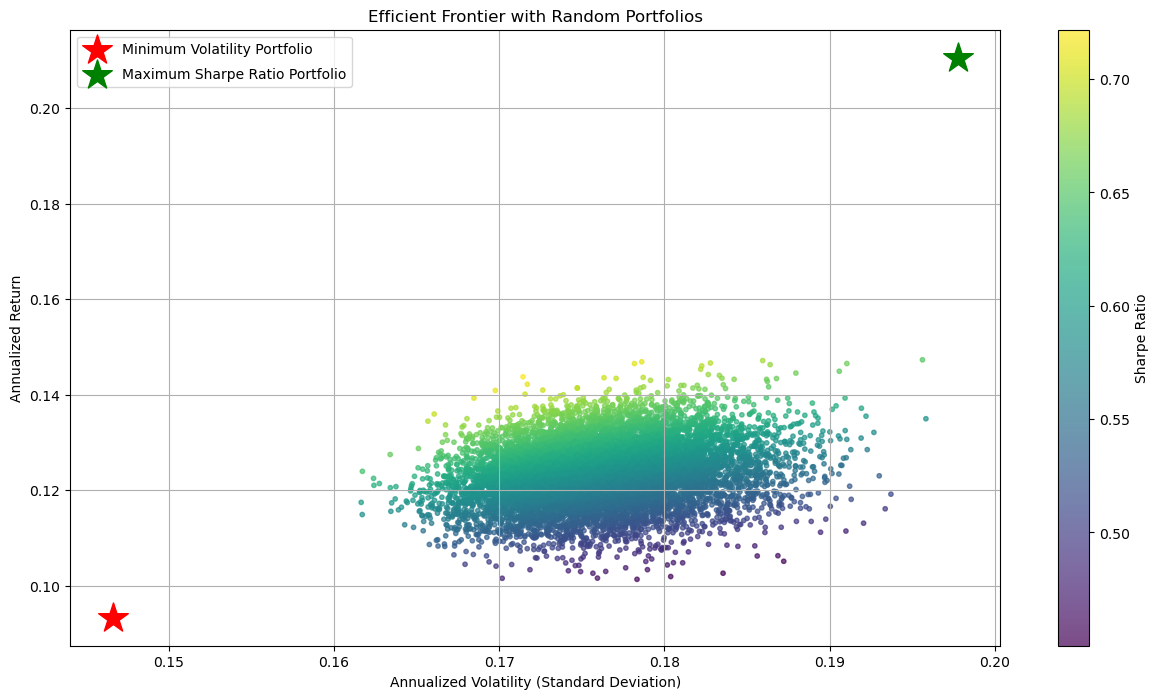

In [24]:
# --- 5.3: Plotting the Efficient Frontier ---

# Generate a large number of random portfolios to approximate the efficient frontier.
num_portfolios = 10000
results = np.zeros((3, num_portfolios)) # Store std_dev, return, sharpe_ratio

for i in range(num_portfolios):
    weights = np.random.random(len(all_tickers))
    weights /= np.sum(weights) # Normalize weights to sum to 1
    portfolio_std_dev, portfolio_return, portfolio_sharpe = portfolio_performance(
        weights, mean_returns, cov_matrix, risk_free_rate
    )
    results[0, i] = portfolio_std_dev
    results[1, i] = portfolio_return
    results[2, i] = portfolio_sharpe

# Convert results to a DataFrame for easier manipulation.
results_frame = pd.DataFrame(results.T, columns=['Std_Dev', 'Return', 'Sharpe_Ratio'])

# Plot the efficient frontier.
plt.figure(figsize=(15, 8))
plt.scatter(results_frame.Std_Dev, results_frame.Return, c=results_frame.Sharpe_Ratio, cmap='viridis', marker='o', s=10, alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier with Random Portfolios')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Return')

# Plot the minimum volatility portfolio.
plt.scatter(min_vol_std_dev, min_vol_return, marker='*', color='red', s=500, label='Minimum Volatility Portfolio')
# Plot the maximum Sharpe ratio portfolio.
plt.scatter(max_sharpe_std_dev, max_sharpe_return, marker='*', color='green', s=500, label='Maximum Sharpe Ratio Portfolio')

plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()


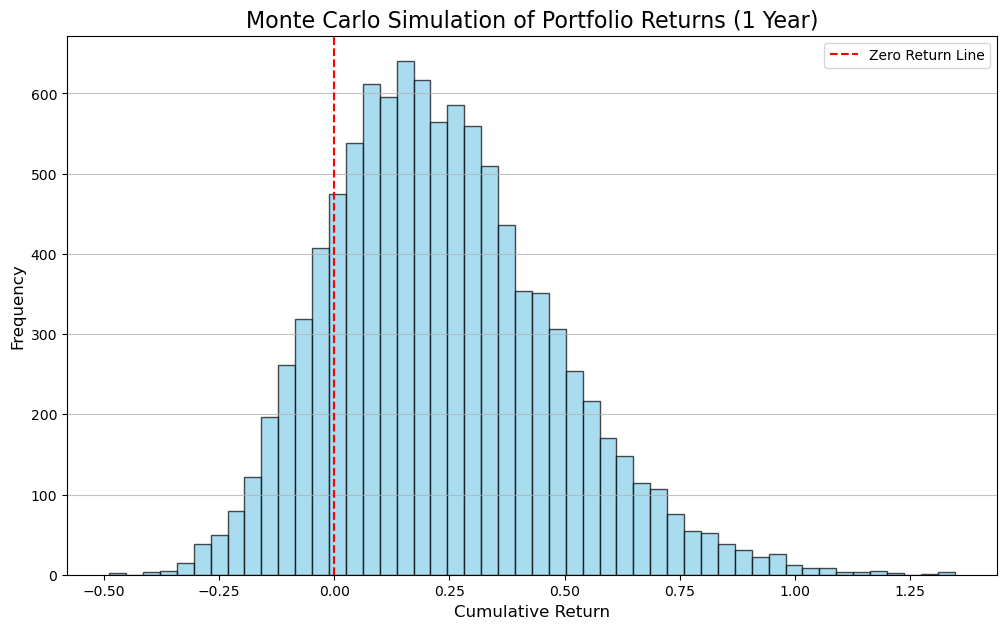

In [26]:
# --- Section 6: Monte Carlo Simulation for Portfolio Returns ---

# Number of simulations to run.
num_simulations = 10000
# Number of trading days in the simulation period (e.g., 1 year).
simulation_days = trading_days # 252 days for 1 year

# Use the weights from the maximum Sharpe Ratio portfolio for simulation.
weights = max_sharpe_weights

# Calculate daily mean returns and covariance matrix from the original daily returns.
# These are not annualized for the daily simulation.
mean_daily_returns = returns.mean()
cov_matrix_daily = returns.cov()

# Array to store simulated cumulative returns.
simulated_returns = np.zeros(num_simulations)

for i in range(num_simulations):
    # Simulate daily returns using a multivariate normal distribution.
    # The distribution is parameterized by daily mean returns and daily covariance matrix.
    simulated_daily_returns = np.random.multivariate_normal(
        mean_daily_returns,
        cov_matrix_daily,
        simulation_days
    )
    # Calculate daily portfolio returns by multiplying simulated daily returns by weights.
    portfolio_daily_returns = simulated_daily_returns @ weights
    # Calculate the cumulative return over the simulation period.
    cumulative_return = np.prod(1 + portfolio_daily_returns) - 1
    simulated_returns[i] = cumulative_return

# Plot a histogram of the simulated portfolio returns.
# This visualizes the distribution of potential future portfolio outcomes.
plt.figure(figsize=(12, 7))
plt.hist(simulated_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Monte Carlo Simulation of Portfolio Returns (1 Year)', fontsize=16)
plt.xlabel('Cumulative Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Return Line')
plt.legend()
plt.show()

In [28]:
# --- Section 7: Monte Carlo VaR and CVaR Calculation ---

# Calculate Monte Carlo Value at Risk (VaR) at the 95% confidence level.
# VaR represents the maximum expected loss over a given time horizon at a given confidence level.
# The 5th percentile means 5% of the simulated returns are worse than this value.
mc_var_95 = np.percentile(simulated_returns, 5)

# Calculate Monte Carlo Conditional Value at Risk (CVaR) at the 95% confidence level.
# CVaR (also known as Expected Shortfall) is the average of all losses that exceed the VaR.
# It provides a more comprehensive measure of tail risk than VaR.
mc_cvar_95 = simulated_returns[simulated_returns <= mc_var_95].mean()

print("\n--- Monte Carlo Risk Metrics (Based on Max Sharpe Portfolio) ---")
print(f"Monte Carlo VaR (95%): {mc_var_95:.2%}")
print(f"Monte Carlo CVaR (95%): {mc_cvar_95:.2%}")


--- Monte Carlo Risk Metrics (Based on Max Sharpe Portfolio) ---
Monte Carlo VaR (95%): -12.35%
Monte Carlo CVaR (95%): -19.19%
